Computing occupancy
=====

Import blockpartyrfid and other useful modules.

In [1]:
%pylab inline

import blockpartyrfid
import numpy
import pylab

Populating the interactive namespace from numpy and matplotlib


Load in data from log directory (that contains event .csvs)

In [2]:
data_directory = '180131'
data = blockpartyrfid.io.load_log_directory(data_directory)

Event data will import as a 5 column array of:

- timestamp in milliseconds
- board number (starting at 0)
- event code (0: rfid, 1: beam, 2: touch, 3: time sync)
- data 0
- data 1

In [3]:
print(data[:5])

[[  1199272738            3            0            1            1]
 [  1199272758            3            0 180395793573            0]
 [  1199272758            3            0            0            1]
 [  1199272871            3            0            1            1]
 [  1199272891            3            0 180395793573            0]]


Data can be filtered using db.sel

In [4]:
rfid_data = blockpartyrfid.db.sel(data, event='rfid', data1=0)
print("N rfid events: %s" % len(rfid_data))

N rfid events: 432487


and grouped using db.split_events

In [5]:
animal_data = blockpartyrfid.db.split_events(rfid_data, board=False, event=False, data0=True, data1=False)

In [6]:
# remove test tag reads, < N reads
minimum_rfid_reads = 100
for a in list(animal_data.keys())[:]:
    print("Animal %s[%s]: %i reads" % (hex(a), a, len(animal_data[a])))
    if len(animal_data[a]) < minimum_rfid_reads:
        print("Removing test tag: %s" % hex(a))
        del animal_data[a]
boards = blockpartyrfid.db.all_boards(data)
animals = list(animal_data.keys())
print("Boards[%s]: %s" % (len(boards), boards, ))
print("Animals[%s]: %s" % (len(animals), [hex(a) for a in animals], ))

Animal 0x2a006d2934[180395780404]: 15703 reads
Animal 0x2a006d2c35[180395781173]: 80629 reads
Animal 0x2a006d2d3a[180395781434]: 28763 reads
Animal 0x2a006d2e25[180395781669]: 62867 reads
Animal 0x2a006d3160[180395782496]: 47631 reads
Animal 0x2a006d3162[180395782498]: 1 reads
Removing test tag: 0x2a006d3162
Animal 0x2a006d395f[180395784543]: 66 reads
Removing test tag: 0x2a006d395f
Animal 0x2a006d3aad[180395784877]: 18748 reads
Animal 0x2a006d5765[180395792229]: 31452 reads
Animal 0x2a006d5ca5[180395793573]: 64173 reads
Animal 0x2a006d6032[180395794482]: 31525 reads
Animal 0x2a006d61b7[180395794871]: 12810 reads
Animal 0x2a006d62c6[180395795142]: 33275 reads
Animal 0x2a006d67ca[180395796426]: 4844 reads
Boards[4]: [0 1 2 3]
Animals[12]: ['0x2a006d2934', '0x2a006d2c35', '0x2a006d2d3a', '0x2a006d2e25', '0x2a006d3160', '0x2a006d3aad', '0x2a006d5765', '0x2a006d5ca5', '0x2a006d6032', '0x2a006d61b7', '0x2a006d62c6', '0x2a006d67ca']


As rfid tags now create multiple reads when in front of the reader, sequential tag reads within some threshold should be merged.

In [7]:
rfid_merge_threshold = None  # set this to None to try and auto-calculate the threshold

if rfid_merge_threshold is None:
    rfid_merge_threshold = numpy.inf
    for a in animals:
        # find dt for sequential tag reads from 2 different tubes
        cbinds = numpy.where(numpy.diff(animal_data[a][:, 1]) != 0)[0]
        cbdt = animal_data[a][cbinds + 1, 0] - animal_data[a][cbinds, 0]

        # find dt for sequential tag reads from same board
        #wbdt = numpy.diff(ad[a][:-1][numpy.diff(ad[a][:, 1]) == 0, 0])

        rfid_merge_threshold = min(rfid_merge_threshold, cbdt.min())

print("Merging rfid reads within %s ms" % rfid_merge_threshold)

Merging rfid reads within 569 ms


In [8]:
rfid_reads = {}
raw_sequences = {}
sequences = {}
occupancy = {}

for a in animals:
    # merge close rfid reads
    rfid_reads[a] = blockpartyrfid.db.merge_close_reads(animal_data[a], rfid_merge_threshold)
    
    # convert rfid reads to sequences, assuming a read = a traversal through the tube
    raw_sequences[a] = blockpartyrfid.occupancy.from_tube_sequence(rfid_reads[a])
    
    # combine all sequences, keeping where they agree
    sequences[a] = blockpartyrfid.occupancy.merge_sequences(raw_sequences[a])
    
    # convert from the sequence structure into occupancy
    occupancy[a] = blockpartyrfid.occupancy.merged_sequence_to_occupancy(sequences[a][0], rfid_reads[a])

When an animal moves through 2 tubes (e.g. 1 then 2) we can infer the animal was in cage 1 between 
these reads (this is a 'start' point). If we then assume that every rfid read is a traversal 
through the tube (and not a poke into the tube) then we can try to predict the location of the 
animal before and after the 'start'. This is all performed in blockpartyrfid.occupancy.from_tube_sequence

We can check if this chain appears correct when it reaches the next 'start' point giving an indication of
the reliability of this method (how many chains succeeded vs failed to predict the next event). This
is performed in blockpartyrfid.occupancy.merge_sequences

In [9]:
for a in animals:
    print("For animal %s, %0.2f%% sequences predicted the next event" % (hex(a), sequences[a][1] * 100))

For animal 0x2a006d2934, 90.93% sequences predicted the next event
For animal 0x2a006d2c35, 95.94% sequences predicted the next event
For animal 0x2a006d2d3a, 95.34% sequences predicted the next event
For animal 0x2a006d2e25, 95.86% sequences predicted the next event
For animal 0x2a006d3160, 93.86% sequences predicted the next event
For animal 0x2a006d3aad, 93.50% sequences predicted the next event
For animal 0x2a006d5765, 93.25% sequences predicted the next event
For animal 0x2a006d5ca5, 95.33% sequences predicted the next event
For animal 0x2a006d6032, 96.89% sequences predicted the next event
For animal 0x2a006d61b7, 95.94% sequences predicted the next event
For animal 0x2a006d62c6, 96.62% sequences predicted the next event
For animal 0x2a006d67ca, 83.13% sequences predicted the next event


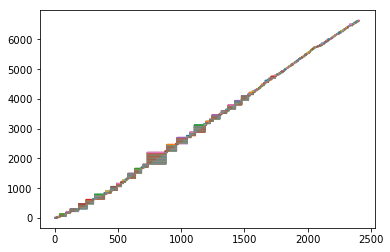

In [10]:
blockpartyrfid.vis.plot_sequence_chain(raw_sequences[a], chain_offset=len(boards) + 1)

In [11]:
# merge per-animal occupancies
o = blockpartyrfid.occupancy.merge_occupancies(occupancy.values())

# save as a .csv file
output_filename = 'occupancy.csv'
numpy.savetxt(output_filename, o, delimiter=',')

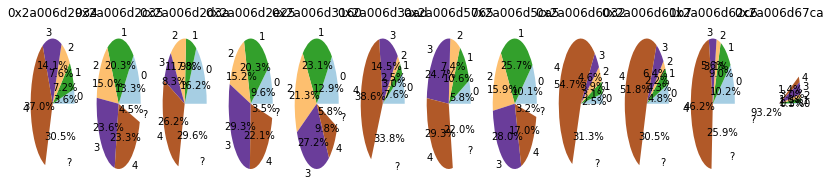

In [12]:
# show time in cage
pylab.figure(figsize=(14, 3))
blockpartyrfid.vis.plot_time_in_cage(o)

Plotting the sequence chains (each offset in y by the number of cages) and looking at the number and 
and location of discrete blocks gives an indication of where the chains 'break'
(areas between blocks are failures to predict the animals location).

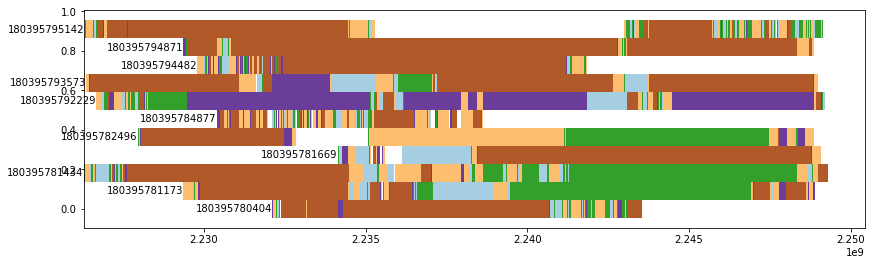

In [13]:
pylab.figure(figsize=(14, 4))
blockpartyrfid.vis.plot_occupancy(o[-1000:])

In [14]:
maes = blockpartyrfid.occupancy.find_multi_animal_events(rfid_reads, rfid_merge_threshold)
cm, cm_animals = blockpartyrfid.occupancy.generate_chase_matrix(maes)

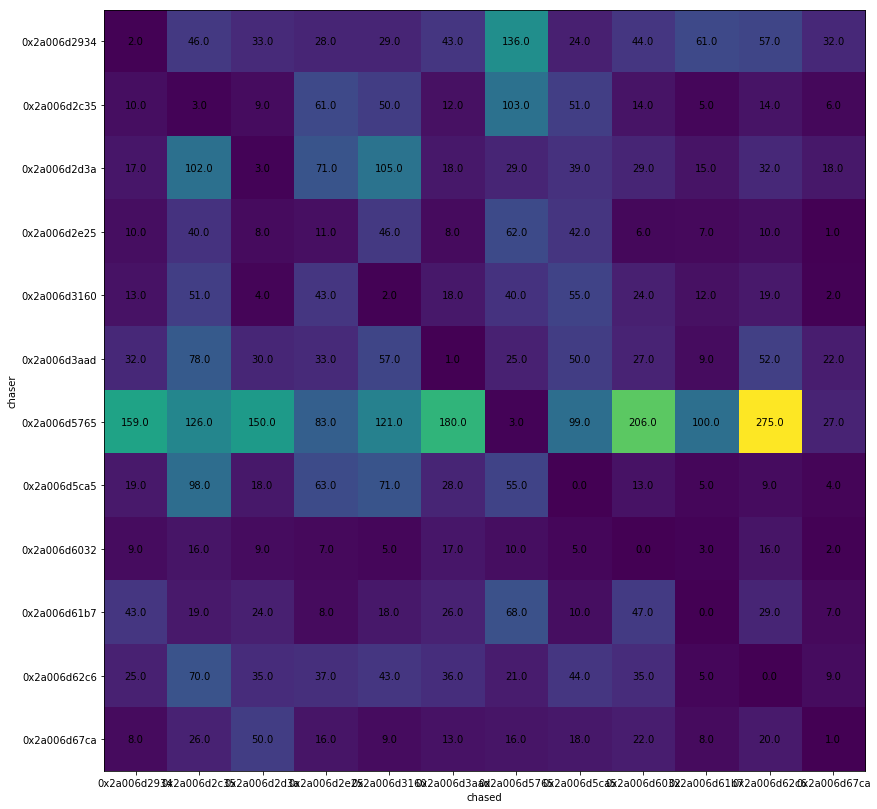

In [15]:
pylab.figure(figsize=(14, 14))
blockpartyrfid.vis.plot_chase_matrix(cm, cm_animals)